In [ ]:
# 1. Importar bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 2. Recolectar y visualizar datos
tickers = ["AAPL", "TSLA", "MSFT", "GOOGL"]
all_data = {ticker: yf.download(ticker, start="2020-01-01", end="2023-01-01") for ticker in tickers}


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Creando un DataFrame con los precios de cierre
df = pd.DataFrame({ticker: data['Close'] for ticker, data in all_data.items()})
print(df.head())

                 AAPL       TSLA        MSFT      GOOGL
Date                                                   
2020-01-02  75.087502  28.684000  160.619995  68.433998
2020-01-03  74.357498  29.534000  158.619995  68.075996
2020-01-06  74.949997  30.102667  159.029999  69.890503
2020-01-07  74.597504  31.270666  157.580002  69.755501
2020-01-08  75.797501  32.809334  160.089996  70.251999


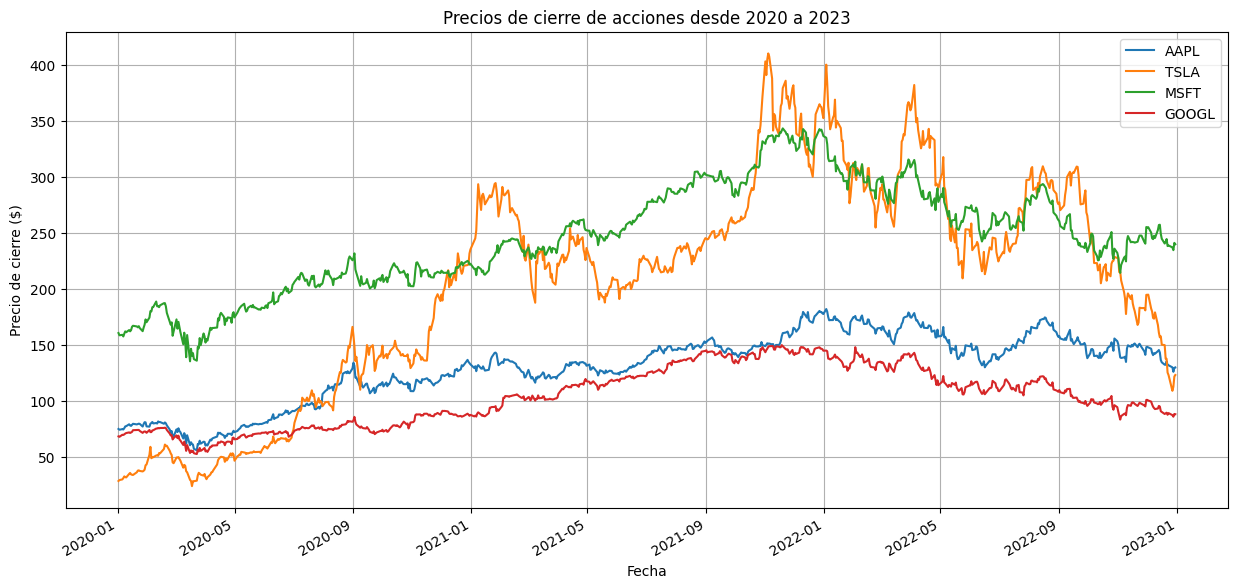

In [ ]:
# Visualización gráfica de los precios de cierre
df.plot(figsize=(15, 7))
plt.title('Precios de cierre de acciones desde 2020 a 2023')
plt.ylabel('Precio de cierre ($)')
plt.xlabel('Fecha')
plt.legend(tickers)
plt.grid(True)
plt.show()

In [ ]:
# Guardar los datos en archivos CSV
for ticker, data in all_data.items():
    data.to_csv(f"{ticker}_2020_2023.csv")

<ipython-input-6-e2b2af4f11f8>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tesla_data = pd.read_csv("TSLA_2020_2023.csv", date_parser=True)


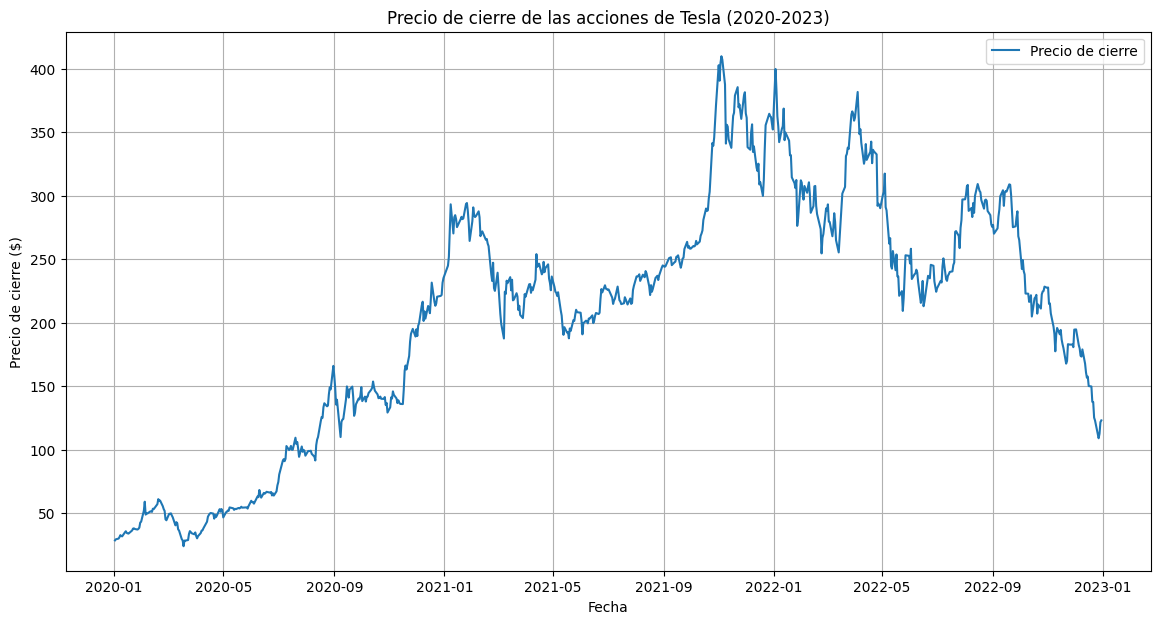

In [ ]:
# Cargar el conjunto de datos
tesla_data = pd.read_csv("TSLA_2020_2023.csv", date_parser=True)
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])

# Visualizar los precios de cierre de las acciones de Tesla
plt.figure(figsize=(14,7))
plt.plot(tesla_data['Date'], tesla_data['Close'], label='Precio de cierre')
plt.title('Precio de cierre de las acciones de Tesla (2020-2023)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 2. Preprocesamiento de los datos

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Crear secuencias de entrenamiento
X = []  # características (60 días previos)
y = []  # objetivo (precio del día siguiente)

sequence_length = 60
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, X_test.shape


((556, 60, 1), (140, 60, 1))

In [ ]:
# Construcción del modelo LSTM
model = Sequential()

# Primera capa LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Segunda capa LSTM
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Tercera capa LSTM
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(units=1))

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Evaluación del modelo
loss = model.evaluate(X_test, y_test, verbose=1)

# Predicción de los precios
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)



Epoch 1/100
18/18 [==============================] - 20s 204ms/step - loss: 0.1077 - val_loss: 0.0127
Epoch 2/100
18/18 [==============================] - 2s 108ms/step - loss: 0.0191 - val_loss: 0.0052
Epoch 3/100
18/18 [==============================] - 1s 81ms/step - loss: 0.0081 - val_loss: 0.0034
Epoch 4/100
18/18 [==============================] - 1s 80ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 5/100
18/18 [==============================] - 1s 79ms/step - loss: 0.0066 - val_loss: 0.0030
Epoch 6/100
18/18 [==============================] - 1s 81ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 7/100
18/18 [==============================] - 1s 81ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 8/100
18/18 [==============================] - 1s 80ms/step - loss: 0.0071 - val_loss: 0.0035
Epoch 9/100
18/18 [==============================] - 2s 105ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/100
18/18 [==============================] - 2s 113ms/step - loss: 0.0057 - val_loss: 0

Epoch 1/50
19/19 [==============================] - 5s 27ms/step - loss: 0.0617
Epoch 2/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0071
Epoch 3/50
19/19 [==============================] - 1s 26ms/step - loss: 0.0028
Epoch 4/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0013
Epoch 5/50
19/19 [==============================] - 1s 26ms/step - loss: 0.0013
Epoch 6/50
19/19 [==============================] - 1s 26ms/step - loss: 0.0012
Epoch 7/50
19/19 [==============================] - 1s 28ms/step - loss: 0.0011
Epoch 8/50
19/19 [==============================] - 1s 26ms/step - loss: 0.0010
Epoch 9/50
19/19 [==============================] - 1s 27ms/step - loss: 9.9213e-04
Epoch 10/50
19/19 [==============================] - 1s 28ms/step - loss: 9.6855e-04
Epoch 11/50
19/19 [==============================] - 1s 27ms/step - loss: 9.6659e-04
Epoch 12/50
19/19 [==============================] - 0s 26ms/step - loss: 9.2951e-04
Epoch 13/50
19/19 [==

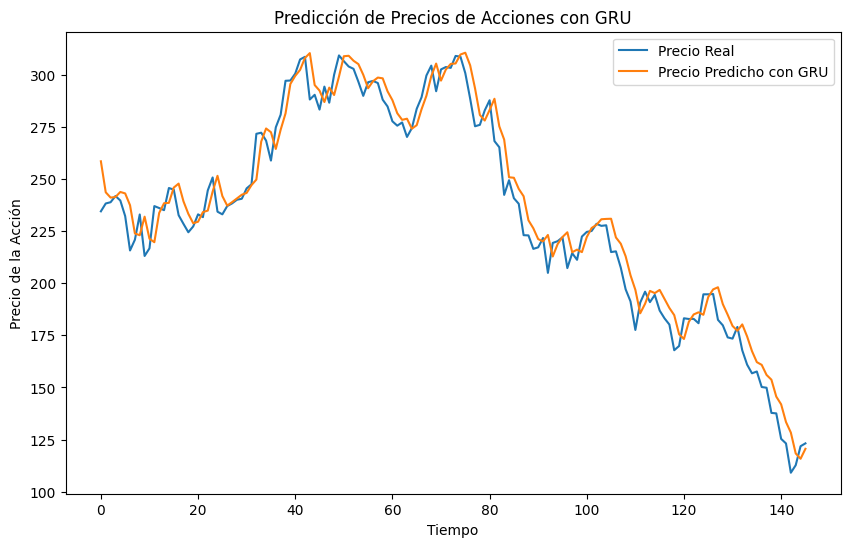

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_csv('TSLA_2020_2023.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Escalar la columna 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Función para crear secuencias
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Tamaño de ventana y creación de secuencias
window_size = 30
X, y = create_sequences(scaled_data, window_size)

# División en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Redimensionar para GRU
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo GRU
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(window_size, 1)),
    GRU(50),
    Dense(1)
])

# Compilación del modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predicciones
predicted_prices = model_gru.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Precios reales
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Precio Real')
plt.plot(predicted_prices, label='Precio Predicho con GRU')
plt.title('Predicción de Precios de Acciones con GRU')
plt.xlabel('Tiempo')
plt.ylabel('Precio de la Acción')
plt.legend()
plt.show()
